# Homework part I

### Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ (2 pts) Find out how the algorithm performance changes if you use a different `percentile` and/or `n_sessions`. Provide here some figures so we can see how the hyperparameters influence the performance.
- __1.2__ (1 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


#### Report
- __1.1 Done.__ Can be seen in crossentropy_method_prob_matrix.ipynb and in deep_crossentropy_method.ipynb
- __1.2 Done.__ Can be seen in crossentropy_method_prob_matrix.ipynb and in deep_crossentropy_method.ipynb

# Homework part II

### Deep crossentropy method

By this moment, you should have got enough score on [CartPole-v0](https://gymnasium.farama.org/environments/classic_control/cart_pole/) to consider it solved (see the link). It's time to try something harder.

* if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks

* __2.1__ (3 pts) Pick one of environments: `MountainCar-v0` or `LunarLander-v2`.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get some of the points depending on the result, so don't be afraid to submit it.
  
  
* __2.2__ (up to 6 pts) Devise a way to speed up training against the default version
  * Obvious improvement: use [`joblib`](https://joblib.readthedocs.io/en/latest/). However, note that you will probably need to spawn a new environment in each of the workers instead of passing it via pickling. (2 pts)
  * Try re-using samples from 3-5 last iterations when computing threshold and training. (2 pts)
  * Obtain __-100__ at `MountainCar-v0` or __+200__ at `LunarLander-v2` (2 pts). Feel free to experiment with hyperparameters, architectures, schedules etc.
  
__Please list what you did in Anytask submission form__. This reduces probability that somebody misses something.
  
  
### Tips
* Gymnasium pages: [MountainCar](https://gymnasium.farama.org/environments/classic_control/mountain_car/), [LunarLander](https://gymnasium.farama.org/environments/box2d/lunar_lander/)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 10% are better, than if you use percentile 20% as threshold, R >= threshold __fails to cut off bad sessions__ while R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it doesn't train, it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.

You may find the following snippet useful:

#### Report
- __2.1__ Choce LunarLander-v2 as it seems mode difficult. Got the average score > 100

### LunarLander-v2

(array([ 0.00570612,  1.3990337 ,  0.5779653 , -0.5282997 , -0.0066053 ,
       -0.13091765,  0.        ,  0.        ], dtype=float32), {})


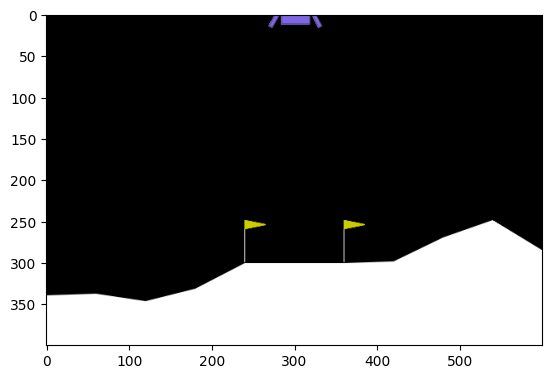

In [59]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

env = gym.make("LunarLander-v2", render_mode="rgb_array")
print(env.reset(seed=0))
plt.imshow(env.render())


In [60]:
n_states = env.observation_space
n_actions = env.action_space.n

print(f"n_states={n_states}, n_actions={n_actions}")
print(f"Actions num: {n_actions}")

n_states=Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32), n_actions=4
Actions num: 4


In [61]:
help(env.unwrapped)

Help on LunarLander in module gymnasium.envs.box2d.lunar_lander object:

class LunarLander(gymnasium.core.Env, gymnasium.utils.ezpickle.EzPickle)
 |  LunarLander(render_mode: Optional[str] = None, continuous: bool = False, gravity: float = -10.0, enable_wind: bool = False, wind_power: float = 15.0, turbulence_power: float = 1.5)
 |
 |  ## Description
 |  This environment is a classic rocket trajectory optimization problem.
 |  According to Pontryagin's maximum principle, it is optimal to fire the
 |  engine at full throttle or turn it off. This is the reason why this
 |  environment has discrete actions: engine on or off.
 |
 |  There are two environment versions: discrete or continuous.
 |  The landing pad is always at coordinates (0,0). The coordinates are the
 |  first two numbers in the state vector.
 |  Landing outside of the landing pad is possible. Fuel is infinite, so an agent
 |  can learn to fly and then land on its first attempt.
 |
 |  To see a heuristic landing, run:
 |  `

### Agent initialization

In [65]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation="relu",
    solver='adam',
    learning_rate_init=3e-4
    
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(hidden_layer_sizes=(20, 20), learning_rate_init=0.0003)

### Env generation + functions for elite selection

In [16]:
def generate_session(env, agent, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s, _ = env.reset()

    for t in range(t_max):

        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba([s])[0]

        assert probs.shape == (env.action_space.n,), "make sure probabilities are a vector (hint: np.reshape)"

        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        a = np.random.choice(np.arange(n_actions), p=probs)
        # ^-- hint: try np.random.choice

        new_s, r, terminated, truncated, _ = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if terminated or truncated:
            break
    return states, np.array(actions).tolist(), total_reward


In [17]:
dummy_states, dummy_actions, dummy_reward = generate_session(env, agent, t_max=5)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)


states: [[-0.00173016  1.4197643  -0.17526503  0.39307716  0.00201165  0.03970017
   0.          0.        ]
 [-0.00336895  1.4280204  -0.16352865  0.3669348   0.00166765 -0.00687995
   0.          0.        ]
 [-0.00509653  1.4356841  -0.1746746   0.34060895  0.00355899  0.03783058
   0.          0.        ]
 [-0.00676298  1.4427574  -0.16699599  0.31436092  0.00390705  0.0069616
   0.          0.        ]
 [-0.00836449  1.4492269  -0.15885392  0.2875361   0.00262368 -0.02566962
   0.          0.        ]]
actions: [3, 1, 3, 3, 3]
reward: 9.493738285310094


In [20]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    reward_threshold = np.percentile(rewards_batch, percentile)

    elite_states = list()
    elite_actions = list()
    
    for states, actions, reward in zip(states_batch, actions_batch, rewards_batch):
        if reward >= reward_threshold:
            elite_states.extend(states)
            elite_actions.extend(actions)
        else:
            continue

    # print(elite_actions)
    # print(elite_states)
    # elite_states = states_batch[rewards_batch >= reward_threshold]
    # elite_actions = actions_batch[rewards_batch >= reward_threshold]

    return elite_states, elite_actions


In [24]:
from IPython.display import clear_output


def show_progress(rewards_batch, log, percentile):
    """
    A convenience function that displays training progress.
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label="Mean rewards")
    plt.plot(list(zip(*log))[1], label="Reward thresholds")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch)
    plt.vlines(
        [np.percentile(rewards_batch, percentile)],
        [0],
        [100],
        label="percentile",
        color="red",
    )
    plt.legend()
    plt.grid()

    plt.show()


### Training

mean reward = 68.292, threshold=247.641


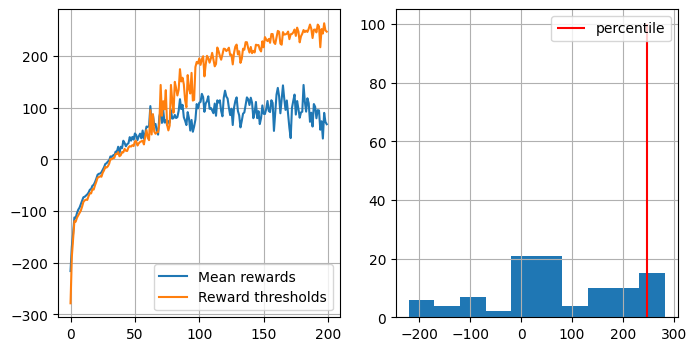

In [66]:
n_sessions = 100
n_epochs = 200
min_percentile = 30
max_percentile = 90
log = []

for i in range(n_epochs):
    percentile = min_percentile + (i+1)/n_epochs * (max_percentile - min_percentile)
    # generate new sessions
    sessions = [generate_session(env, agent, t_max=1000) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile=percentile)

    agent.fit(elite_states, elite_actions)

    show_progress(
        rewards_batch, log, percentile
    )

    if np.mean(rewards_batch) > 150:
        print("You Win! You may stop training now via KeyboardInterrupt.")


### Video

In [67]:
!rm -rf videos/LunarLander/

In [68]:
# Record sessions

from gymnasium.wrappers import RecordVideo

with RecordVideo(
    env=gym.make("LunarLander-v2", render_mode="rgb_array"),
    video_folder="./videos/LunarLander",
    episode_trigger=lambda episode_number: True,
) as env_monitor:
    sessions = [generate_session(env_monitor, agent) for _ in range(5)]


Moviepy - Building video /home/vladimir/my_projects/study/Practical_RL/week01_intro/videos/LunarLander/rl-video-episode-0.mp4.
Moviepy - Writing video /home/vladimir/my_projects/study/Practical_RL/week01_intro/videos/LunarLander/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/vladimir/my_projects/study/Practical_RL/week01_intro/videos/LunarLander/rl-video-episode-0.mp4
Moviepy - Building video /home/vladimir/my_projects/study/Practical_RL/week01_intro/videos/LunarLander/rl-video-episode-1.mp4.
Moviepy - Writing video /home/vladimir/my_projects/study/Practical_RL/week01_intro/videos/LunarLander/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /home/vladimir/my_projects/study/Practical_RL/week01_intro/videos/LunarLander/rl-video-episode-1.mp4
Moviepy - Building video /home/vladimir/my_projects/study/Practical_RL/week01_intro/videos/LunarLander/rl-video-episode-2.mp4.
Moviepy - Writing video /home/vladimir/my_projects/study/Practical_RL/week01_intro/videos/LunarLander/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /home/vladimir/my_projects/study/Practical_RL/week01_intro/videos/LunarLander/rl-video-episode-2.mp4


Moviepy - Building video /home/vladimir/my_projects/study/Practical_RL/week01_intro/videos/LunarLander/rl-video-episode-3.mp4.
Moviepy - Writing video /home/vladimir/my_projects/study/Practical_RL/week01_intro/videos/LunarLander/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /home/vladimir/my_projects/study/Practical_RL/week01_intro/videos/LunarLander/rl-video-episode-3.mp4
Moviepy - Building video /home/vladimir/my_projects/study/Practical_RL/week01_intro/videos/LunarLander/rl-video-episode-4.mp4.
Moviepy - Writing video /home/vladimir/my_projects/study/Practical_RL/week01_intro/videos/LunarLander/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /home/vladimir/my_projects/study/Practical_RL/week01_intro/videos/LunarLander/rl-video-episode-4.mp4


In [71]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path("videos/LunarLander/").iterdir() if s.suffix == ".mp4"])
video_path = video_paths[1]  # You can also try other indices


data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)


### Bonus tasks

* __2.3 bonus__ (2 pts) Try to find a network architecture and training params that solve __both__ environments above (_Points depend on implementation. If you attempted this task, please mention it in Anytask submission._)

* __2.4 bonus__ (4 pts) Solve continuous action space task with `MLPRegressor` or similar.
  * Since your agent only predicts the "expected" action, you will have to add noise to ensure exploration.
  * Choose one of [MountainCarContinuous-v0](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/) (90+ pts to solve), [LunarLanderContinuous-v2](https://gymnasium.farama.org/environments/box2d/lunar_lander/) (`env = gym.make("LunarLander-v2", continuous=True)`)(200+ pts to solve)
  * 4 points for solving. Slightly less for getting some results below solution threshold. Note that discrete and continuous environments may have slightly different rules, aside from action spaces.